# XGBoost Model for GNSS Positioning Reliability Prediction

This notebook builds a time-series aware XGBoost classifier to predict GNSS positioning reliability. The workflow includes optimized data loading, time-series feature engineering, strict temporal split, model training, evaluation, and feature importance analysis.

In [3]:
# Cell 1: Setup & Optimized Loading
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

sns.set_style("whitegrid")

# Load data
df = pd.read_parquet('data/processed/all_data_compressed.parquet')

# Impute missing DOP columns with -1, signal columns with 0
dop_cols = [col for col in df.columns if 'DOP' in col or col == 'pDOP']
signal_cols = ['cnoMean', 'numSatsTracked']
for col in dop_cols:
    if col in df.columns:
        df[col] = df[col].fillna(-1)
for col in signal_cols:
    if col in df.columns:
        df[col] = df[col].fillna(0)

df.head()

,timestamp,fixType,gnssFixOk,numSV,hAcc,vAcc,tAcc,sAcc,pDOP,hDOP,...,nDOP,eDOP,numSatsTracked,cnoMean,cnoStd,cnoMin,cnoMax,horizontalPositionLabel,verticalPositionLabel,overallPositionLabel
0,2025-08-01 11:23:56.435470,3,1,31,1.235,1.248,0.024,0.075,-1.00,-1.0,...,-1.00,-1.00,0,0.000000,NaN,NaN,NaN,0,0,0
1,2025-08-01 11:23:56.462573,3,1,31,1.235,1.248,0.024,0.075,-1.00,-1.0,...,-1.00,-1.00,30,35.900002,10.2,17.0,53.0,0,0,0
2,2025-08-01 11:23:56.467906,3,1,31,1.235,1.248,0.024,0.075,0.88,0.5,...,0.39,0.31,30,35.900002,10.2,17.0,53.0,0,0,0
3,2025-08-01 11:23:56.948525,3,1,30,1.237,1.249,0.024,0.096,0.88,0.5,...,0.39,0.31,30,35.900002,10.2,17.0,53.0,0,0,0
4,2025-08-01 11:23:56.976757,3,1,30,1.237,1.249,0.024,0.096,0.88,0.5,...,0.39,0.31,29,36.000000,10.4,17.0,53.0,0,0,0


## Missing Value Analysis & Imputation Strategy

This section quantifies missing data in DOP and Signal columns, visualizes missingness patterns, and applies a domain-specific imputation strategy based on GNSS physical principles.

## Exploratory Data Analysis (EDA): Feature Distributions & Class Imbalance

This section visualizes the distribution of key GNSS features by reliability class and analyzes class imbalance globally and per file.

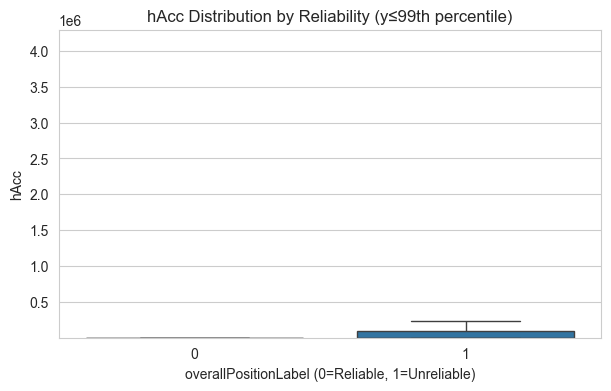

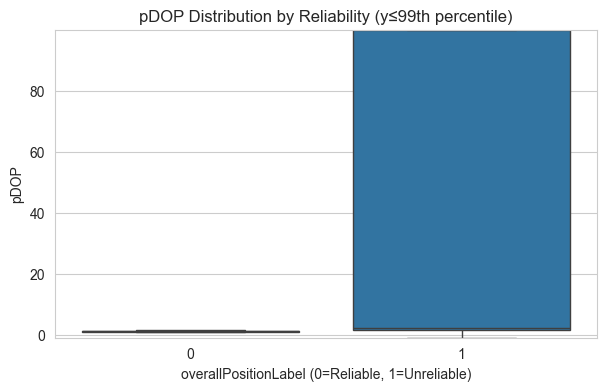

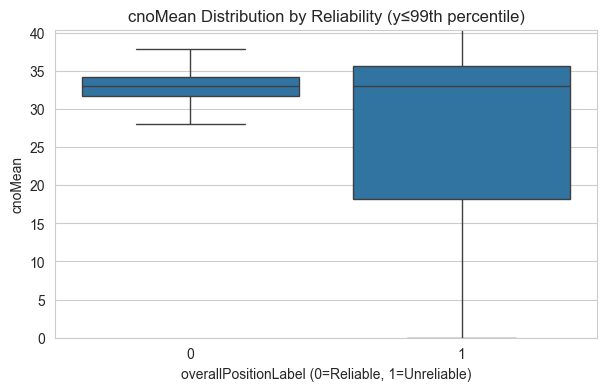

In [47]:
# Task 1: Feature Distribution by Target
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure figures directory exists (both root and notebooks/)
os.makedirs('figures', exist_ok=True)
os.makedirs('notebooks/figures', exist_ok=True)

features = ['hAcc', 'pDOP', 'cnoMean']
percentile = 99  # Limit y-axis to 99th percentile

for feat in features:
    plt.figure(figsize=(7, 4))
    if feat in df.columns:
        # Calculate y-limit
        upper = np.nanpercentile(df[feat], percentile)
        sns.boxplot(
            data=df,
            x='overallPositionLabel',
            y=feat,
            showfliers=False
        )
        plt.ylim(df[feat].min(), upper)
        plt.xlabel('overallPositionLabel (0=Reliable, 1=Unreliable)')
        plt.title(f'{feat} Distribution by Reliability (y≤{percentile}th percentile)')
        plt.grid(True, axis='y')
        plt.savefig(f'figures/xgb_feat_dist_{feat}.png', bbox_inches='tight', dpi=150)
        plt.savefig(f'notebooks/figures/xgb_feat_dist_{feat}.png', bbox_inches='tight', dpi=150)
        plt.show()

Global Stats:
✅ Reliable:   7207882    (73.39%)
❌ Unreliable: 2613137    (26.61%)
------------------------------
⚠️ Колонку 'filename' не знайдено. Групую дані по ДАТАХ (Date).

Top 5 Worst Dates by Failure Rate:
            Failure Rate (%)
date_temp                   
2025-11-28         79.073401
2025-12-01         54.014804
2025-12-14         51.866596
2025-11-27         48.383737
2025-12-13         47.542065


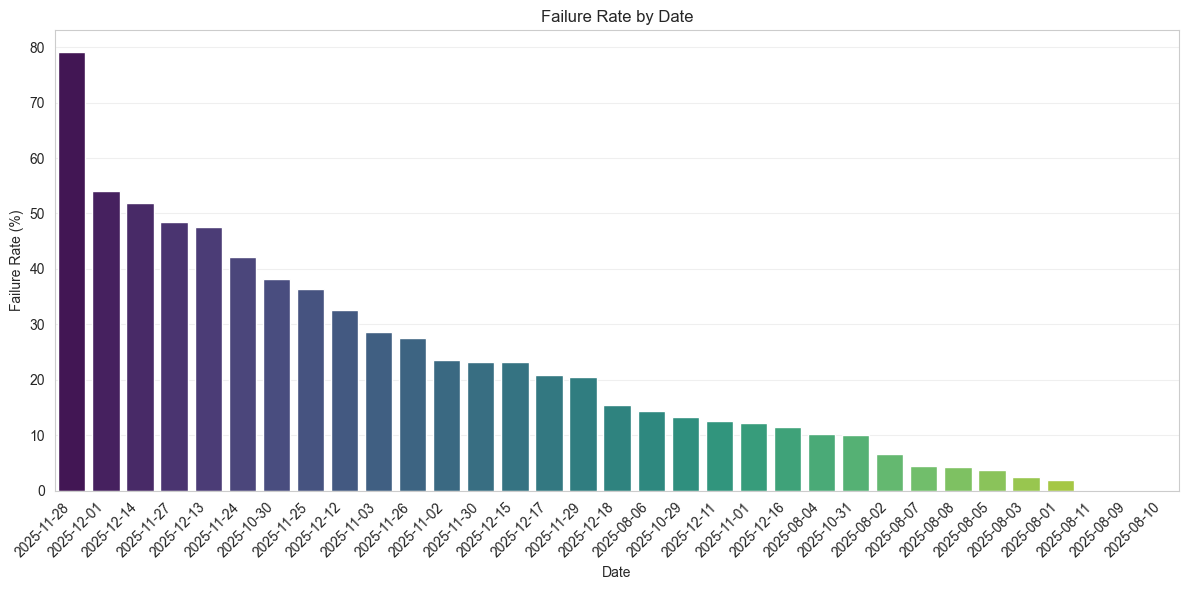

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Глобальна статистика
reliable = (df['overallPositionLabel'] == 0).sum()
unreliable = (df['overallPositionLabel'] == 1).sum()
total = len(df)

print(f"Global Stats:")
print(f"✅ Reliable:   {reliable:<10} ({100*reliable/total:.2f}%)")
print(f"❌ Unreliable: {unreliable:<10} ({100*unreliable/total:.2f}%)")
print("-" * 30)

# 2. Пошук колонки для групування (Файл або Дата)
group_col = None
col_type = "File"

# Спробуємо знайти колонку з назвою файлу
for col in df.columns:
    if 'file' in col.lower() or 'source' in col.lower():
        group_col = col
        break

# Якщо колонку файлу не знайдено, спробуємо згрупувати по даті (якщо є timestamp)
if group_col is None and 'timestamp' in df.columns:
    print("⚠️ Колонку 'filename' не знайдено. Групую дані по ДАТАХ (Date).")
    df['date_temp'] = df['timestamp'].dt.date.astype(str)
    group_col = 'date_temp'
    col_type = "Date"

# 3. Аналіз та візуалізація
if group_col:
    # Рахуємо статистику
    file_stats = df.groupby(group_col)['overallPositionLabel'].agg(['count', 'sum'])
    file_stats['Failure Rate (%)'] = 100 * file_stats['sum'] / file_stats['count']
    
    # Сортуємо від найбільш проблемних до найменш проблемних
    file_stats = file_stats.sort_values('Failure Rate (%)', ascending=False)

    # Виводимо топ-5 найгірших файлів/днів текстом
    print(f"\nTop 5 Worst {col_type}s by Failure Rate:")
    print(file_stats.head(5)[['Failure Rate (%)']])

    # Малюємо графік
    plt.figure(figsize=(12, 6))
    barplot = sns.barplot(
    x=file_stats.index, 
    y=file_stats['Failure Rate (%)'], 
    hue=file_stats.index,  # Фарбуємо стовпчики в залежності від дати
    legend=False,          # Прибираємо легенду (вона тут зайва)
    palette='viridis'
    )
    
    plt.ylabel('Failure Rate (%)')
    plt.xlabel(col_type)
    plt.title(f'Failure Rate by {col_type}')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, axis='y', alpha=0.3)
    
    # Якщо це тимчасова колонка дати, видаляємо її після використання
    if group_col == 'date_temp':
        df.drop(columns=['date_temp'], inplace=True)
        
    plt.tight_layout()
    plt.savefig(f'figures/xgb_failure_rate_by_{col_type.lower()}.png', bbox_inches='tight', dpi=150)
    plt.show()
else:
    print("❌ Не знайдено ні колонки 'filename', ні 'timestamp' для аналізу.")

## Hypothesis Testing: Directional Jamming & Spoofing Analysis

This section explores GNSS anomalies potentially caused by military Electronic Warfare (EW), focusing on directional jamming (East vs North DOP), spoofing (hidden failures), and temporal attack patterns.

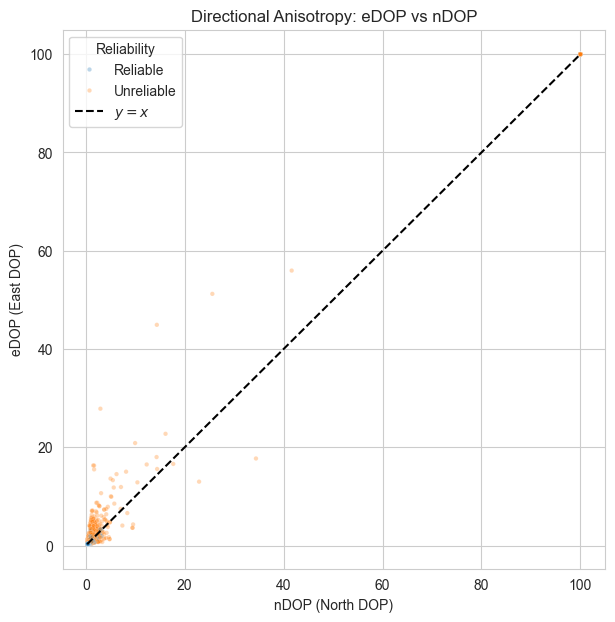

In [49]:
# Plot 1: Directional Anisotropy (eDOP vs nDOP)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sample 50,000 points where eDOP > 0 and nDOP > 0
plot1_df = df[(df['eDOP'] > 0) & (df['nDOP'] > 0)].sample(n=50000, random_state=42)

plt.figure(figsize=(7, 7))
sns.scatterplot(
    data=plot1_df,
    x='nDOP', y='eDOP',
    hue=plot1_df['overallPositionLabel'].map({0: 'Reliable', 1: 'Unreliable'}),
    alpha=0.3, s=10
)
plt.plot([plot1_df['nDOP'].min(), plot1_df['nDOP'].max()],
         [plot1_df['nDOP'].min(), plot1_df['nDOP'].max()],
         ls='--', color='black', label='$y=x$')
plt.xlabel('nDOP (North DOP)')
plt.ylabel('eDOP (East DOP)')
plt.title('Directional Anisotropy: eDOP vs nDOP')
plt.legend(title='Reliability')
plt.grid(True)
plt.savefig('figures/xgb_edop_vs_ndop.png', bbox_inches='tight', dpi=150)
plt.show()

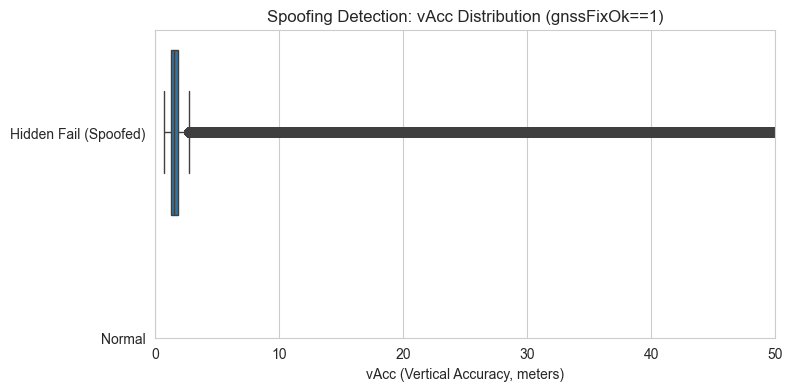

In [51]:
# Plot 2: Spoofing Detection (Hidden Failures)
# Candidates: gnssFixOk == 1
spoofed = df[(df['gnssFixOk'] == 1) & (df['overallPositionLabel'] == 1)]
normal = df[(df['gnssFixOk'] == 1) & (df['overallPositionLabel'] == 0)]

# Prepare for boxplot
groups = [
    spoofed['vAcc'].dropna(),
    normal['vAcc'].dropna()
]
labels = ['Hidden Fail (Spoofed)', 'Normal']

plt.figure(figsize=(8, 4))
sns.boxplot(data=groups, orient='h')
plt.yticks([0, 1], labels)
plt.xlabel('vAcc (Vertical Accuracy, meters)')
plt.xlim(0, 50)
plt.title('Spoofing Detection: vAcc Distribution (gnssFixOk==1)')
plt.grid(True, axis='x')
plt.savefig('figures/xgb_spoofing_vacc.png', bbox_inches='tight', dpi=150)
plt.show()

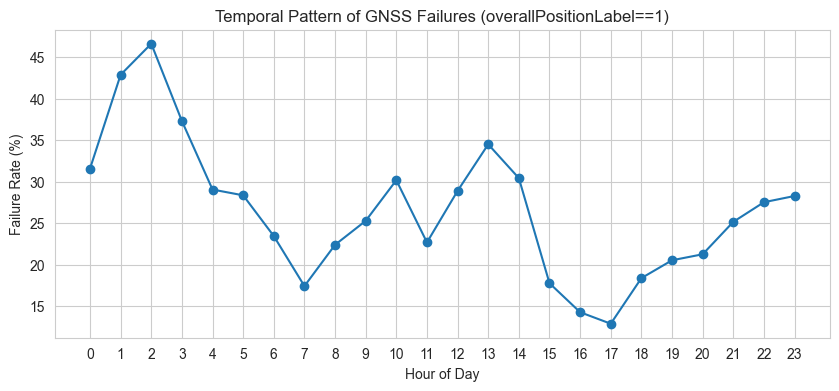

In [52]:
# Plot 3: Temporal Attack Pattern
# Extract hour from timestamp
if not np.issubdtype(df['timestamp'].dtype, np.datetime64):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour

# Calculate failure rate per hour
hourly = df.groupby('hour')['overallPositionLabel'].agg(['count', 'sum'])
hourly['Failure Rate (%)'] = 100 * hourly['sum'] / hourly['count']

plt.figure(figsize=(10, 4))
plt.plot(hourly.index, hourly['Failure Rate (%)'], marker='o')
plt.xticks(range(0, 24))
plt.xlabel('Hour of Day')
plt.ylabel('Failure Rate (%)')
plt.title('Temporal Pattern of GNSS Failures (overallPositionLabel==1)')
plt.grid(True)
plt.savefig('figures/xgb_failure_rate_by_hour.png', bbox_inches='tight', dpi=150)
plt.show()

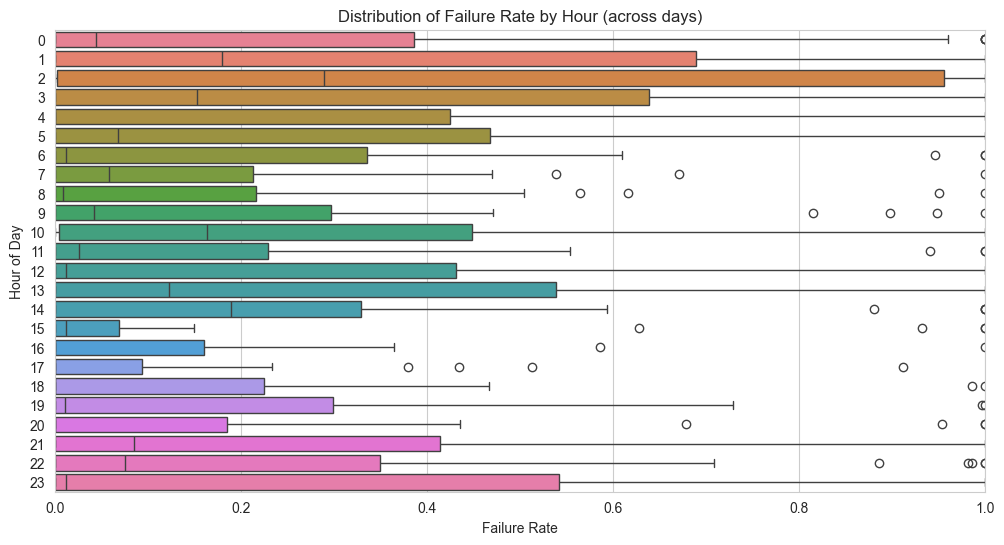

Std deviation of failure rate by hour:
hour
0     0.381206
1     0.393844
2     0.434665
3     0.411604
4     0.385816
5     0.350748
6     0.335965
7     0.253321
8     0.289624
9     0.338230
10    0.319006
11    0.322931
12    0.360293
13    0.361637
14    0.343730
15    0.331638
16    0.229666
17    0.222421
18    0.289652
19    0.306000
20    0.326012
21    0.324675
22    0.382494
23    0.362772
dtype: float64


In [53]:
# Systematicity Check: Failure Rate Variability by Hour (Boxplot)
# Group by day and hour to see how failure rate varies across days for each hour

df['date'] = df['timestamp'].dt.date
failures_by_hour_day = df.groupby(['date', 'hour'])['overallPositionLabel'].agg(['count', 'sum'])
failures_by_hour_day['Failure Rate'] = failures_by_hour_day['sum'] / failures_by_hour_day['count']

# Pivot to get hours as columns, days as rows
pivot = failures_by_hour_day.reset_index().pivot(index='date', columns='hour', values='Failure Rate')

plt.figure(figsize=(12, 6))
sns.boxplot(data=pivot, orient='h')
plt.xlabel('Failure Rate')
plt.ylabel('Hour of Day')
plt.title('Distribution of Failure Rate by Hour (across days)')
plt.xlim(0, 1)
plt.grid(True, axis='x')
plt.savefig('figures/xgb_failure_rate_hour_boxplot.png', bbox_inches='tight', dpi=150)
plt.show()

# Std deviation per hour (systematicity metric)
hourly_std = pivot.std(skipna=True)
print('Std deviation of failure rate by hour:')
print(hourly_std)

## Deep Dive: Internal Receiver State & Jamming Efficiency Analysis

This section investigates internal GNSS receiver metrics to uncover hidden patterns of jamming and spoofing, focusing on satellite utilization, dead zones, speed accuracy, and signal instability.

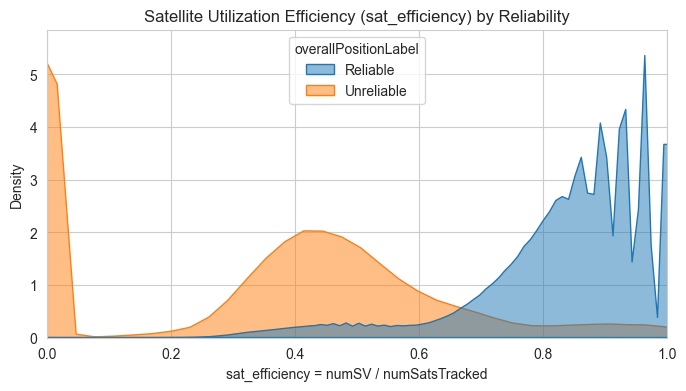

In [54]:
# Analysis 1: Satellite Utilization Efficiency ("Phantom Satellites")
df['sat_efficiency'] = df['numSV'] / df['numSatsTracked']
df['sat_efficiency'] = df['sat_efficiency'].replace([np.inf, -np.inf], np.nan).fillna(0)

plt.figure(figsize=(8, 4))
sns.kdeplot(
    data=df,
    x='sat_efficiency',
    hue=df['overallPositionLabel'].map({0: 'Reliable', 1: 'Unreliable'}),
    common_norm=False,
    fill=True,
    alpha=0.5
)
plt.title('Satellite Utilization Efficiency (sat_efficiency) by Reliability')
plt.xlabel('sat_efficiency = numSV / numSatsTracked')
plt.xlim(0, 1)
plt.grid(True)
plt.savefig('figures/xgb_sat_efficiency.png', bbox_inches='tight', dpi=150)
plt.show()

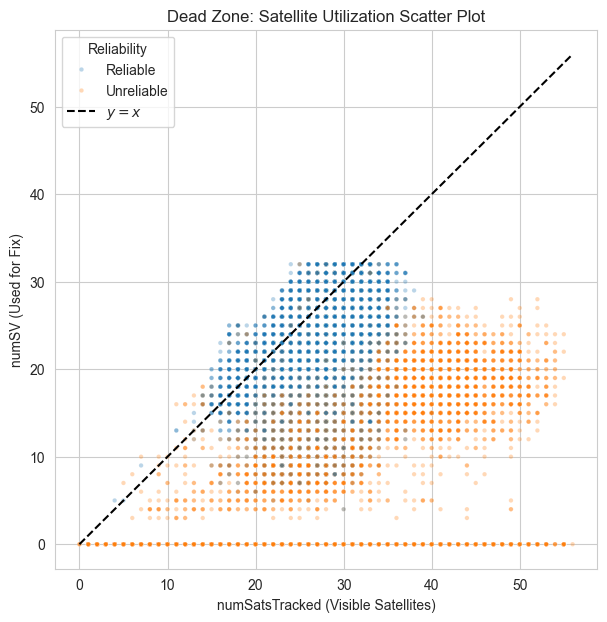

In [55]:
# Analysis 2: The "Dead Zone" Scatter Plot
sample_df = df.sample(n=50000, random_state=42)

plt.figure(figsize=(7, 7))
sns.scatterplot(
    data=sample_df,
    x='numSatsTracked', y='numSV',
    hue=sample_df['overallPositionLabel'].map({0: 'Reliable', 1: 'Unreliable'}),
    alpha=0.3, s=10
)
plt.plot([sample_df['numSatsTracked'].min(), sample_df['numSatsTracked'].max()],
         [sample_df['numSatsTracked'].min(), sample_df['numSatsTracked'].max()],
         ls='--', color='black', label='$y=x$')
plt.xlabel('numSatsTracked (Visible Satellites)')
plt.ylabel('numSV (Used for Fix)')
plt.title('Dead Zone: Satellite Utilization Scatter Plot')
plt.legend(title='Reliability')
plt.grid(True)
plt.savefig('figures/xgb_dead_zone_scatter.png', bbox_inches='tight', dpi=150)
plt.show()

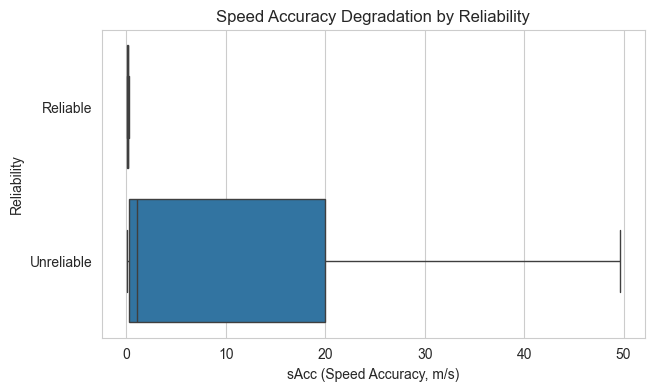

In [56]:
# Analysis 3: Speed Accuracy Degradation (sAcc)
plt.figure(figsize=(7, 4))
sns.boxplot(
    data=df,
    x='sAcc',
    y=df['overallPositionLabel'].map({0: 'Reliable', 1: 'Unreliable'}),
    showfliers=False
)
plt.ylabel('Reliability')
plt.xlabel('sAcc (Speed Accuracy, m/s)')
plt.title('Speed Accuracy Degradation by Reliability')
plt.grid(True, axis='x')
plt.savefig('figures/xgb_speed_accuracy_degradation.png', bbox_inches='tight', dpi=150)
plt.show()

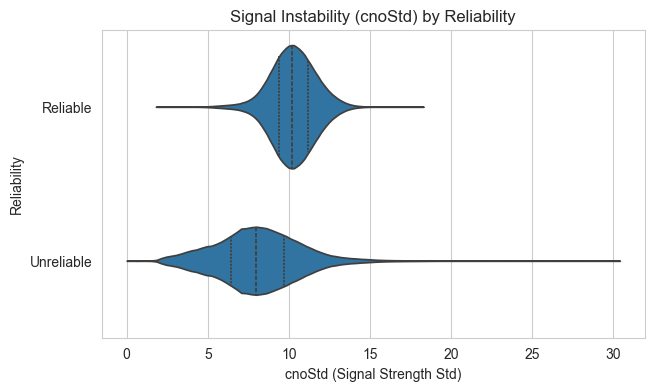

Pearson correlations with overallPositionLabel:
sat_efficiency: -0.759
sAcc: 0.314
cnoStd: -0.466


In [57]:
# Analysis 4: Signal Instability (cnoStd)
plt.figure(figsize=(7, 4))
sns.violinplot(
    data=df,
    x='cnoStd',
    y=df['overallPositionLabel'].map({0: 'Reliable', 1: 'Unreliable'}),
    inner='quartile',
    cut=0
)
plt.ylabel('Reliability')
plt.xlabel('cnoStd (Signal Strength Std)')
plt.title('Signal Instability (cnoStd) by Reliability')
plt.grid(True, axis='x')
plt.savefig('figures/xgb_signal_instability.png', bbox_inches='tight', dpi=150)
plt.show()

# Output Correlations
metrics = ['sat_efficiency', 'sAcc', 'cnoStd']
corrs = {}
for m in metrics:
    if m in df.columns:
        corrs[m] = df[m].corr(df['overallPositionLabel'])
print('Pearson correlations with overallPositionLabel:')
for k, v in corrs.items():
    print(f'{k}: {v:.3f}')

In [58]:
# Step 1: Quantify Missing Data (All Columns)
import pandas as pd

# Reload to ensure fresh state for missing value analysis
missing_df = pd.read_parquet('data/processed/all_data_compressed.parquet')

# Calculate missing for all columns
total_rows = len(missing_df)
missing_stats = []
for col in missing_df.columns:
    miss_count = missing_df[col].isnull().sum()
    miss_pct = 100 * miss_count / total_rows
    missing_stats.append({
        'Column': col,
        'Missing Count': miss_count,
        'Missing %': round(miss_pct, 2)
    })

missing_table = pd.DataFrame(missing_stats).sort_values('Missing %', ascending=False)
print('Missing Value Summary (All Columns):')
print(missing_table)

Missing Value Summary (All Columns):
                     Column  Missing Count  Missing %
17                   cnoStd           5354       0.05
19                   cnoMax            759       0.01
16                  cnoMean            759       0.01
18                   cnoMin            759       0.01
0                 timestamp              0       0.00
1                   fixType              0       0.00
2                 gnssFixOk              0       0.00
6                      tAcc              0       0.00
5                      vAcc              0       0.00
4                      hAcc              0       0.00
3                     numSV              0       0.00
7                      sAcc              0       0.00
8                      pDOP             11       0.00
9                      hDOP             11       0.00
10                     vDOP             11       0.00
14                     eDOP             11       0.00
13                     nDOP             11   

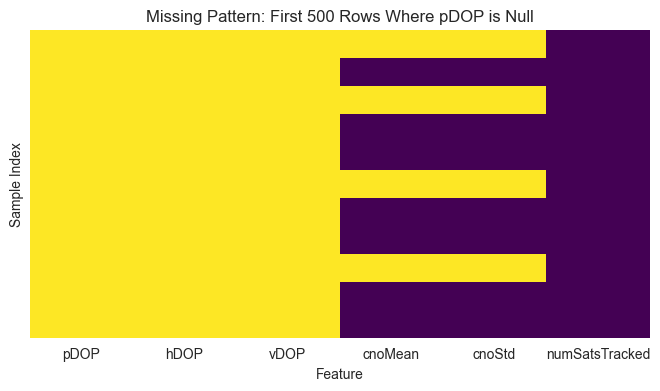

In [59]:
# Step 2: Visualize Missing Patterns
import matplotlib.pyplot as plt
import seaborn as sns

# Sample first 500 rows where pDOP is null
sample_null = missing_df[missing_df['pDOP'].isnull()].head(500)

if len(sample_null) > 0:
    plt.figure(figsize=(8, 4))
    sns.heatmap(sample_null[DOP_COLS + SIGNAL_COLS].isnull(),
                cbar=False, cmap='viridis', yticklabels=False)
    plt.title('Missing Pattern: First 500 Rows Where pDOP is Null')
    plt.xlabel('Feature')
    plt.ylabel('Sample Index')
    plt.savefig('figures/xgb_missing_pattern_pdop_null.png', bbox_inches='tight', dpi=150)
    plt.show()
else:
    print('No rows found where pDOP is null.')

In [60]:
# Step 3: Apply Imputation Strategy (Domain-Specific)
def gnss_impute(df):
    # Rule A: DOP columns to -1
    for col in DOP_COLS:
        if col in df.columns:
            df[col] = df[col].fillna(-1)
    # Rule B: Signal columns to 0
    for col in SIGNAL_COLS:
        if col in df.columns:
            df[col] = df[col].fillna(0)
    return df

imputed_df = gnss_impute(missing_df.copy())

In [18]:
# Step 4: Verification & Sanity Check
# Ensure no missing values remain
missing_total = imputed_df.isnull().sum().sum()
print(f"Total missing values after imputation: {missing_total}")

# Show descriptive statistics for pDOP (should include -1)
if 'pDOP' in imputed_df.columns:
    print(imputed_df['pDOP'].describe())

Total missing values after imputation: 1562
count    9.821020e+06
mean     9.936746e+00
std      2.790215e+01
min     -1.000000e+00
25%      1.010000e+00
50%      1.120000e+00
75%      1.470000e+00
max      9.999000e+01
Name: pDOP, dtype: float64


In [61]:
import os
os.chdir("..")
print("Changed working directory:", os.getcwd())

Changed working directory: c:\Users\HOME\Desktop


In [62]:
# Strict Time-Series Train/Test Split (No Leakage)
# 1. Sort by timestamp

df = df.sort_values('timestamp').reset_index(drop=True)

# 2. Extract month from timestamp
if not np.issubdtype(df['timestamp'].dtype, np.datetime64):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
df['month'] = df['timestamp'].dt.month

# 3. Define train/test split
train_idx = df['month'] < 12  # Months 8, 10, 11
test_idx = df['month'] == 12  # Month 12 only

# 4. Define X and y
target_col = 'overallPositionLabel'
label_cols = ['timestamp', 'overallPositionLabel', 'horizontalPositionLabel', 'verticalPositionLabel', 'month']
feature_cols = [col for col in df.columns if col not in label_cols]

X_train = df.loc[train_idx, feature_cols]
y_train = df.loc[train_idx, target_col]
X_test = df.loc[test_idx, feature_cols]
y_test = df.loc[test_idx, target_col]

# 5. Verification
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"Train date range: {df.loc[train_idx, 'timestamp'].min()} to {df.loc[train_idx, 'timestamp'].max()}")
print(f"Test date range: {df.loc[test_idx, 'timestamp'].min()} to {df.loc[test_idx, 'timestamp'].max()}")

X_train shape: (6768514, 26), X_test shape: (3052505, 26)
Train date range: 2025-08-01 11:23:56.462573 to 2025-11-30 23:59:59.116928
Test date range: 2025-12-01 00:00:00.105903 to 2025-12-18 06:45:01.292953


In [63]:
# Cell 3: Strict Time-Series Split
# Extract month from timestamp
df['month'] = pd.to_datetime(df['timestamp']).dt.month

# Train: month < 12 (Aug, Oct, Nov), Test: month == 12 (Dec)
train_idx = df['month'] < 12
test_idx = df['month'] == 12

feature_cols = [col for col in df.columns if col not in ['timestamp', 'overallPositionLabel', 'horizontalPositionLabel', 'verticalPositionLabel', 'month']]

X_train = df.loc[train_idx, feature_cols]
y_train = df.loc[train_idx, 'overallPositionLabel']
X_test = df.loc[test_idx, feature_cols]
y_test = df.loc[test_idx, 'overallPositionLabel']

print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")

X_train shape: (6768514, 26), X_test shape: (3052505, 26)


In [64]:
# Cell 4: Train XGBoost Classifier
from xgboost import XGBClassifier

# Remove any datetime/date columns from features (X_train/X_test)
drop_types = ['datetime64[ns]', 'datetime64', 'timedelta64[ns]', 'object']
drop_cols = [col for col in X_train.columns if np.issubdtype(X_train[col].dtype, np.datetime64) or X_train[col].dtype == 'O']
if 'date' in X_train.columns:
    drop_cols.append('date')
if drop_cols:
    X_train = X_train.drop(columns=drop_cols)
    X_test = X_test.drop(columns=drop_cols)

# Calculate scale_pos_weight for class imbalance
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos

model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    n_jobs=-1,
    tree_method='hist',
    eval_metric='logloss'
)
model.fit(X_train, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

              precision    recall  f1-score   support

           0      0.969     0.949     0.959   2136250
           1      0.886     0.930     0.908    916255

    accuracy                          0.943   3052505
   macro avg      0.928     0.939     0.933   3052505
weighted avg      0.944     0.943     0.944   3052505

Matthews Correlation Coefficient (MCC): 0.867


FileNotFoundError: [Errno 2] No such file or directory: 'figures/xgb_confusion_matrix.png'

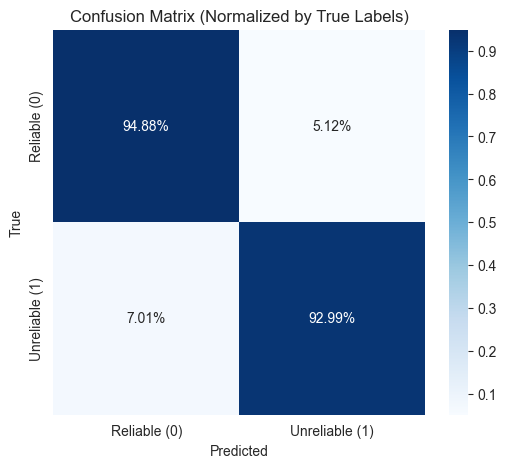

In [65]:
# Cell 5: Evaluation & Metrics
from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef

y_pred = model.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred, digits=3))

# MCC
mcc = matthews_corrcoef(y_test, y_pred)
print(f"Matthews Correlation Coefficient (MCC): {mcc:.3f}")

# Confusion matrix (absolute)
cm = confusion_matrix(y_test, y_pred)

cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6, 5))

sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues', 
            xticklabels=['Reliable (0)', 'Unreliable (1)'], 
            yticklabels=['Reliable (0)', 'Unreliable (1)'])

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Normalized by True Labels)')
plt.savefig('figures/xgb_confusion_matrix.png', bbox_inches='tight', dpi=150)
plt.show()

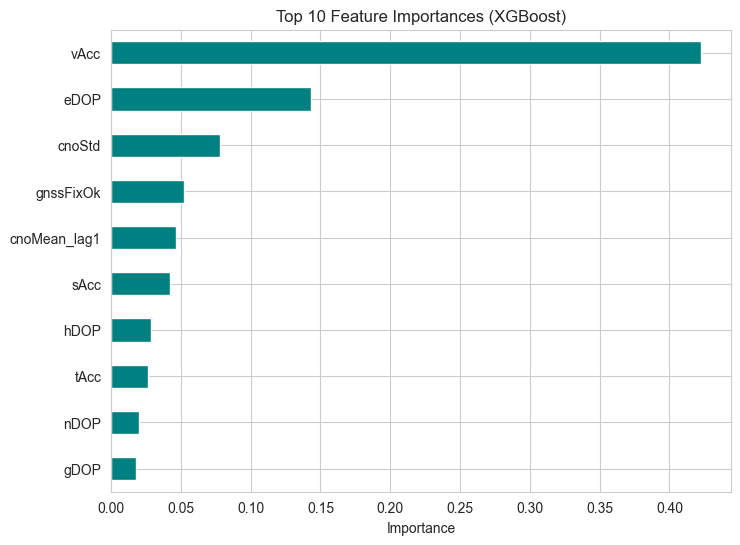

Top 10 features:
vAcc            0.422910
eDOP            0.143553
cnoStd          0.078000
gnssFixOk       0.052217
cnoMean_lag1    0.046632
sAcc            0.042091
hDOP            0.028599
tAcc            0.026288
nDOP            0.020054
gDOP            0.017739
dtype: float32


In [ ]:
# Cell 6: Feature Importance Analysis
importances = model.feature_importances_
features = X_train.columns
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(8,6))
feat_imp.head(10).plot(kind='barh', color='teal')
plt.gca().invert_yaxis()
plt.title('Top 10 Feature Importances (XGBoost)')
plt.xlabel('Importance')
plt.savefig('figures/xgb_top10_feature_importance.png', bbox_inches='tight', dpi=150)
plt.show()

print('Top 10 features:')
print(feat_imp.head(10))

## Data Leakage Investigation: Clean XGBoost Model (Feature Ablation Study)

**Objective:** Assess the impact of potential data leakage from accuracy and DOP metrics by training a "clean" XGBoost model that excludes all direct proxies for the target variable.

**Steps:**
1. Remove all accuracy and DOP features (hAcc, vAcc, sAcc, tAcc, pDOP, hDOP, vDOP, nDOP, eDOP, tDOP, gDOP).
2. Perform strict time-series split (train: months 8-11, test: month 12).
3. Train and evaluate an XGBoostClassifier using only signal and physics-based features.
4. Report classification metrics and plot feature importances for the clean model.

In [66]:
# Step 1: Remove "Giveaway" Features (Accuracy & DOP Metrics)
# Define features to drop
GIVEAWAY_FEATURES = [
    'hAcc', 'vAcc', 'sAcc', 'tAcc',  # Accuracy metrics
    'pDOP', 'hDOP', 'vDOP', 'nDOP', 'eDOP', 'tDOP', 'gDOP'  # DOP metrics
]

# Ensure all features to drop are present in the DataFrame
features_to_drop = [f for f in GIVEAWAY_FEATURES if f in df.columns]
print(f"Dropping features: {features_to_drop}")

# Step 2: Strict Time-Series Split (Train: months 8-11, Test: month 12)
df_sorted = df.sort_values('timestamp').reset_index(drop=True)
if not np.issubdtype(df_sorted['timestamp'].dtype, np.datetime64):
    df_sorted['timestamp'] = pd.to_datetime(df_sorted['timestamp'])
df_sorted['month'] = df_sorted['timestamp'].dt.month

train_idx = df_sorted['month'] < 12
test_idx = df_sorted['month'] == 12

# Step 3: Prepare features (drop giveaway features and non-signal columns)
target_col = 'overallPositionLabel'
label_cols = ['timestamp', 'overallPositionLabel', 'horizontalPositionLabel', 'verticalPositionLabel', 'month']

# Drop giveaway features from feature set
feature_cols_clean = [col for col in df_sorted.columns if col not in label_cols + features_to_drop]

X_train_clean = df_sorted.loc[train_idx, feature_cols_clean]
y_train_clean = df_sorted.loc[train_idx, target_col]
X_test_clean = df_sorted.loc[test_idx, feature_cols_clean]
y_test_clean = df_sorted.loc[test_idx, target_col]

# Remove any datetime or object columns from features
drop_types = ['datetime64[ns]', 'datetime64', 'timedelta64[ns]', 'object']
drop_cols = [col for col in X_train_clean.columns if np.issubdtype(X_train_clean[col].dtype, np.datetime64) or X_train_clean[col].dtype == 'O']
if 'date' in X_train_clean.columns:
    drop_cols.append('date')
if drop_cols:
    X_train_clean = X_train_clean.drop(columns=drop_cols)
    X_test_clean = X_test_clean.drop(columns=drop_cols)

print(f"Final feature set for clean model: {list(X_train_clean.columns)}")

Dropping features: ['hAcc', 'vAcc', 'sAcc', 'tAcc', 'pDOP', 'hDOP', 'vDOP', 'nDOP', 'eDOP', 'tDOP', 'gDOP']
Final feature set for clean model: ['fixType', 'gnssFixOk', 'numSV', 'numSatsTracked', 'cnoMean', 'cnoStd', 'cnoMin', 'cnoMax', 'hAcc_lag1', 'cnoMean_lag1', 'numSV_lag1', 'hAcc_delta', 'hour', 'sat_efficiency']



Classification Report (Clean Model):
              precision    recall  f1-score   support

           0      0.968     0.950     0.959   2136250
           1      0.888     0.926     0.906    916255

    accuracy                          0.943   3052505
   macro avg      0.928     0.938     0.933   3052505
weighted avg      0.944     0.943     0.943   3052505

Matthews Correlation Coefficient (MCC): 0.866


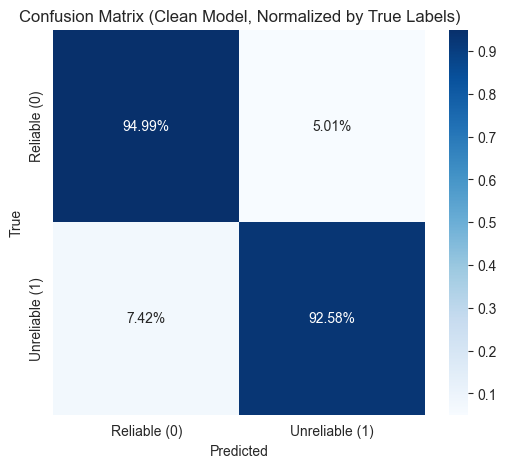

In [67]:
# Step 4: Train & Evaluate Clean XGBoost Model
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef

# Calculate scale_pos_weight for class imbalance
neg, pos = np.bincount(y_train_clean)
scale_pos_weight = neg / pos

clean_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    n_jobs=-1,
    tree_method='hist',
    eval_metric='logloss'
)
clean_model.fit(X_train_clean, y_train_clean)

y_pred_clean = clean_model.predict(X_test_clean)

# Classification report
print("\nClassification Report (Clean Model):")
print(classification_report(y_test_clean, y_pred_clean, digits=3))

# MCC
mcc_clean = matthews_corrcoef(y_test_clean, y_pred_clean)
print(f"Matthews Correlation Coefficient (MCC): {mcc_clean:.3f}")

# Confusion matrix (absolute)
cm_clean = confusion_matrix(y_test_clean, y_pred_clean)
cm_clean_percent = cm_clean.astype('float') / cm_clean.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6, 5))
sns.heatmap(cm_clean_percent, annot=True, fmt='.2%', cmap='Blues', 
            xticklabels=['Reliable (0)', 'Unreliable (1)'], 
            yticklabels=['Reliable (0)', 'Unreliable (1)'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Clean Model, Normalized by True Labels)')
plt.show()

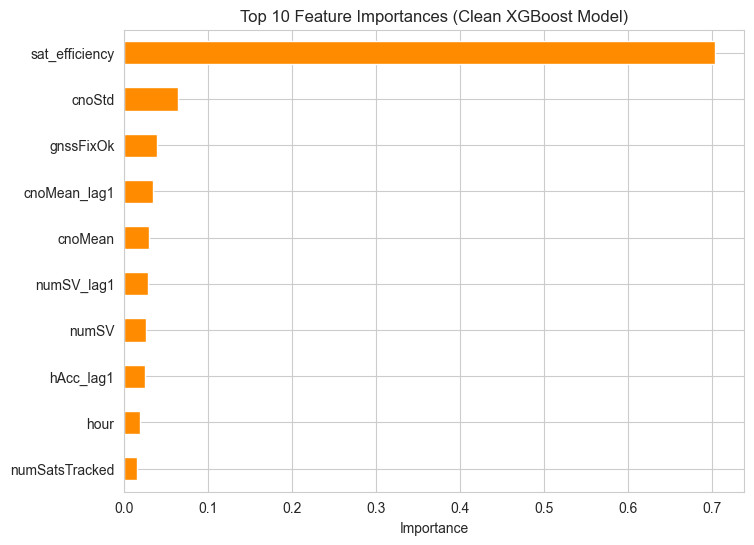

Top 10 features (Clean Model):
sat_efficiency    0.702608
cnoStd            0.064358
gnssFixOk         0.039006
cnoMean_lag1      0.034967
cnoMean           0.029875
numSV_lag1        0.028773
numSV             0.026379
hAcc_lag1         0.025261
hour              0.018640
numSatsTracked    0.014870
dtype: float32


In [45]:
# Step 5: Feature Importance for Clean Model
importances_clean = clean_model.feature_importances_
features_clean = X_train_clean.columns
feat_imp_clean = pd.Series(importances_clean, index=features_clean).sort_values(ascending=False)

plt.figure(figsize=(8,6))
feat_imp_clean.head(10).plot(kind='barh', color='darkorange')
plt.gca().invert_yaxis()
plt.title('Top 10 Feature Importances (Clean XGBoost Model)')
plt.xlabel('Importance')
plt.show()

print('Top 10 features (Clean Model):')
print(feat_imp_clean.head(10))